ECG ST segment [guide](http://litfl.com/st-segment-ecg-library/).

Thalsssemia will be left out of analyses as it is unclear what the numbers refer to.

Target: 0 = disease, 1 = no disease

group cat features' levels to binary when possible

<a id='Data_loading'></a>
## **1. Data Loading and Cleaning** ##

In [71]:
import numpy as np 
import pandas as pd 
import scipy as sp
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

heart = pd.read_csv("./Data/processed.cleveland.csv")
heart.info()
heart.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null object
thal        303 non-null object
target      303 non-null int64
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB


(303, 14)

In [72]:
heart.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [73]:
np.sum(heart == '?')

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

We will need to deal with those question marks.

In [74]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


## Features Description

1. **Age**: displays the age of the individual.
2. **Sex**: displays the gender of the individual using the following format :

    1 = male, 0 = female

3. **Chest-pain type (cp)**: displays the type of chest-pain experienced by the individual using the following format :

    1 = typical angina, 2 = atypical angina, 3 = non — anginal pain, 4 = asymptotic

4. **Resting Blood Pressure (trestbps)**: displays the resting blood pressure value of an individual in mmHg (unit)
5. **Serum Cholestrol (chol)**: displays the serum cholesterol in mg/dl (unit)
6. **Fasting Blood Sugar (fbs)**: compares the fasting blood sugar value of an individual with 120mg/dl.

    If fasting blood sugar > 120mg/dl then : 1 (true), else : 0 (false)
7. **Resting ECG (restecg)**: displays resting electrocardiographic results

    0 = normal, 1 = having ST-T wave abnormality, 2 = left ventricular hyperthrophy

8. **Max heart rate achieved (thalch)**: displays the max heart rate achieved by an individual.
9. **Exercise induced angina (exang)**:

    0 = no

10. **ST depression induced by exercise relative to rest (old peak)**: displays the value which is an integer or float.
11. **Peak exercise ST segment (slope)**:

    1 = upsloping, 2 = flat, 3 = downsloping

12. **Number of major vessels (0–3) colored by flourosopy (ca)**: displays the value as integer or float.
13. **Thalassemia (thal)**: displays the thalassemia, which is an inherited blood disorder that causes your body to have less hemoglobin than normal:

    3 = normal, 6 = fixed defect, 7 = reversible defect

14. **Diagnosis of heart disease (target)**: Displays whether the individual is suffering from heart disease or not :

    0 = absence, 1, 2, 3, 4 = present.

In [75]:
# rename columns
heart.columns = ['age', 'sex', 'chest_pain_type', 'rest_BP', 'cholesterol', 'fast_blood_sugar', 'rest_ECG', 'max_HR', 'ex_induced_angina', 
               'ST_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [76]:
# label the levels of categorical features

heart['sex'] = ['Male' if s else 'Female' for s in heart['sex']] # label sex columns
heart['target'] = ['No Heart Disease' if t == 0 else 'Heart Disease' for t in heart['target']] # change target to binary
heart['chest_pain_type'] = heart['chest_pain_type'].astype('category').cat.rename_categories(['asymptomatic', 'typical angina','atypical angina', 'anginanon-anginal'])
heart['fast_blood_sugar'] = heart['fast_blood_sugar'].astype('category').cat.rename_categories(['lower than 120mg/dl', 'higher than 120mg/dl'])
heart['rest_ECG'] = heart['rest_ECG'].astype('category').cat.rename_categories(['left ventricular hypertrophy', 'normal', 'ST-T wave abnormality'])
heart['ex_induced_angina'] = heart['ex_induced_angina'].astype('category').cat.rename_categories(['no', 'yes'])
heart['st_slope'] = heart['st_slope'].astype('category').cat.rename_categories(['downslope', 'flat', 'upslope'])
# replace '?' in num_major_vessels with median
heart.num_major_vessels = heart.num_major_vessels.replace('?', None)
heart.num_major_vessels = heart.num_major_vessels.replace('None', heart['num_major_vessels'].median())
heart['num_major_vessels'] = heart['num_major_vessels'].astype('category').cat.rename_categories(['0', '1', '2', '3'])
# replace '?' in thalassemia with median
heart.thalassemia = heart.thalassemia.replace('?', None)
heart.thalassemia = heart.thalassemia.replace('None', heart['thalassemia'].median())
heart['thalassemia'] = heart['thalassemia'].astype('category').cat.rename_categories(['normal', 'fixed defect', 'reversable defect'])


<a id='EDA'></a>
## **2. Exploratory Data Analysis** ##

In [77]:
heart.head()

,age,sex,chest_pain_type,rest_BP,cholesterol,fast_blood_sugar,rest_ECG,max_HR,ex_induced_angina,ST_depression,st_slope,num_major_vessels,thalassemia,target
0,63,Male,asymptomatic,145,233,higher than 120mg/dl,ST-T wave abnormality,150,no,2.3,upslope,0,fixed defect,No Heart Disease
1,67,Male,anginanon-anginal,160,286,lower than 120mg/dl,ST-T wave abnormality,108,yes,1.5,flat,3,normal,Heart Disease
2,67,Male,anginanon-anginal,120,229,lower than 120mg/dl,ST-T wave abnormality,129,yes,2.6,flat,2,reversable defect,Heart Disease
3,37,Male,atypical angina,130,250,lower than 120mg/dl,left ventricular hypertrophy,187,no,3.5,upslope,0,normal,No Heart Disease
4,41,Female,typical angina,130,204,lower than 120mg/dl,ST-T wave abnormality,172,no,1.4,downslope,0,normal,No Heart Disease


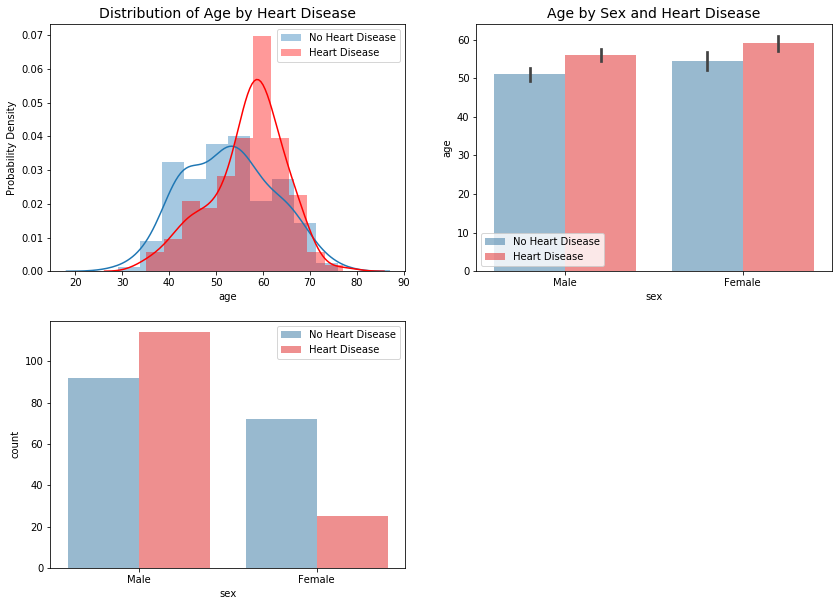

In [78]:
fig = plt.figure(figsize=(14,10))

# Distribution of Age by Heart Disease
ax1 = fig.add_subplot(221)
plt.title('Distribution of Age by Heart Disease', fontsize=14)
sns.distplot(heart[heart['target']=='No Heart Disease'].age, label='No Heart Disease', ax=ax1)
sns.distplot(heart[heart['target']=='Heart Disease'].age, label='Heart Disease', color='red', ax=ax1)
plt.ylabel('Probability Density')
plt.legend()

# Age by Sex and Heart Disease
ax2 = fig.add_subplot(222)
plt.title('Age by Sex and Heart Disease', fontsize=14)
sns.catplot(x='sex', y='age', data=heart, hue='target', palette={'No Heart Disease':'tab:blue','Heart Disease':'red'}, alpha=.5, kind='bar', ax=ax2)
handles, labels = ax2.get_legend_handles_labels() # get the handles of subplot
ax2.legend(handles=handles, labels=['No Heart Disease', 'Heart Disease'])

# Frequency of Heart Disease by Sex
ax3 = fig.add_subplot(223)
plt.title('Frequency of Heart Disease by Sex', fontsize=14)
sns.countplot(x="sex", hue="target", palette={'No Heart Disease':'tab:blue','Heart Disease':'red'}, alpha=.5, data=heart, ax=ax3)
plt.legend(labels=['No Heart Disease', 'Heart Disease'])
ax3.legend(handles=handles, labels=['No Heart Disease', 'Heart Disease'])

plt.close(2)
plt.show()

We can see that 

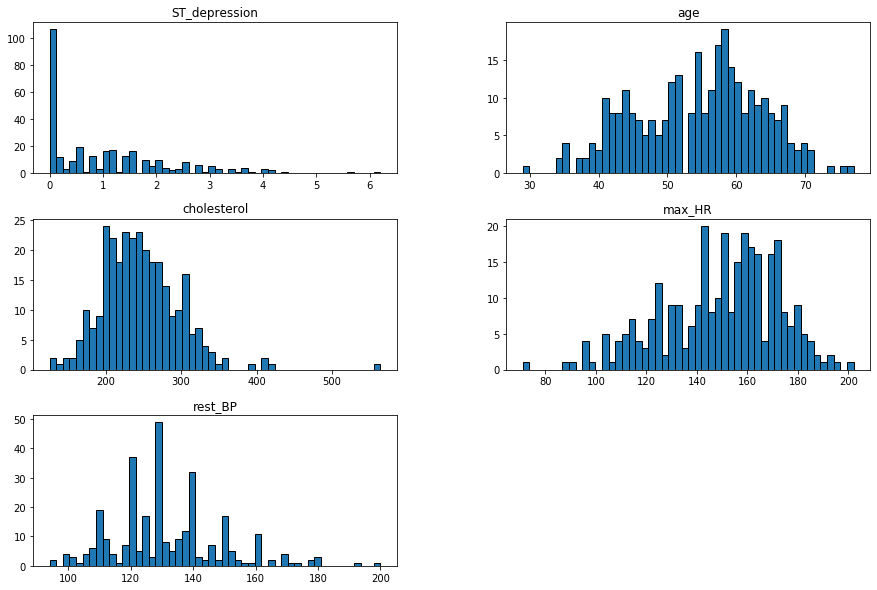

In [79]:
# Plot distribution for each variable
heart.hist(bins=50, figsize=(15, 10), grid=False, edgecolor='black')
plt.show()

In [80]:
heart[heart['cholesterol'] > 500]

,age,sex,chest_pain_type,rest_BP,cholesterol,fast_blood_sugar,rest_ECG,max_HR,ex_induced_angina,ST_depression,st_slope,num_major_vessels,thalassemia,target
152,67,Female,atypical angina,115,564,lower than 120mg/dl,ST-T wave abnormality,160,no,1.6,flat,0,reversable defect,No Heart Disease


ST_depression is highly skewed while cholesterol appears to have an extreme outlier that might need removal

In [81]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age                  303 non-null int64
sex                  303 non-null object
chest_pain_type      303 non-null category
rest_BP              303 non-null int64
cholesterol          303 non-null int64
fast_blood_sugar     303 non-null category
rest_ECG             303 non-null category
max_HR               303 non-null int64
ex_induced_angina    303 non-null category
ST_depression        303 non-null float64
st_slope             303 non-null category
num_major_vessels    303 non-null category
thalassemia          303 non-null category
target               303 non-null object
dtypes: category(7), float64(1), int64(4), object(2)
memory usage: 19.6+ KB


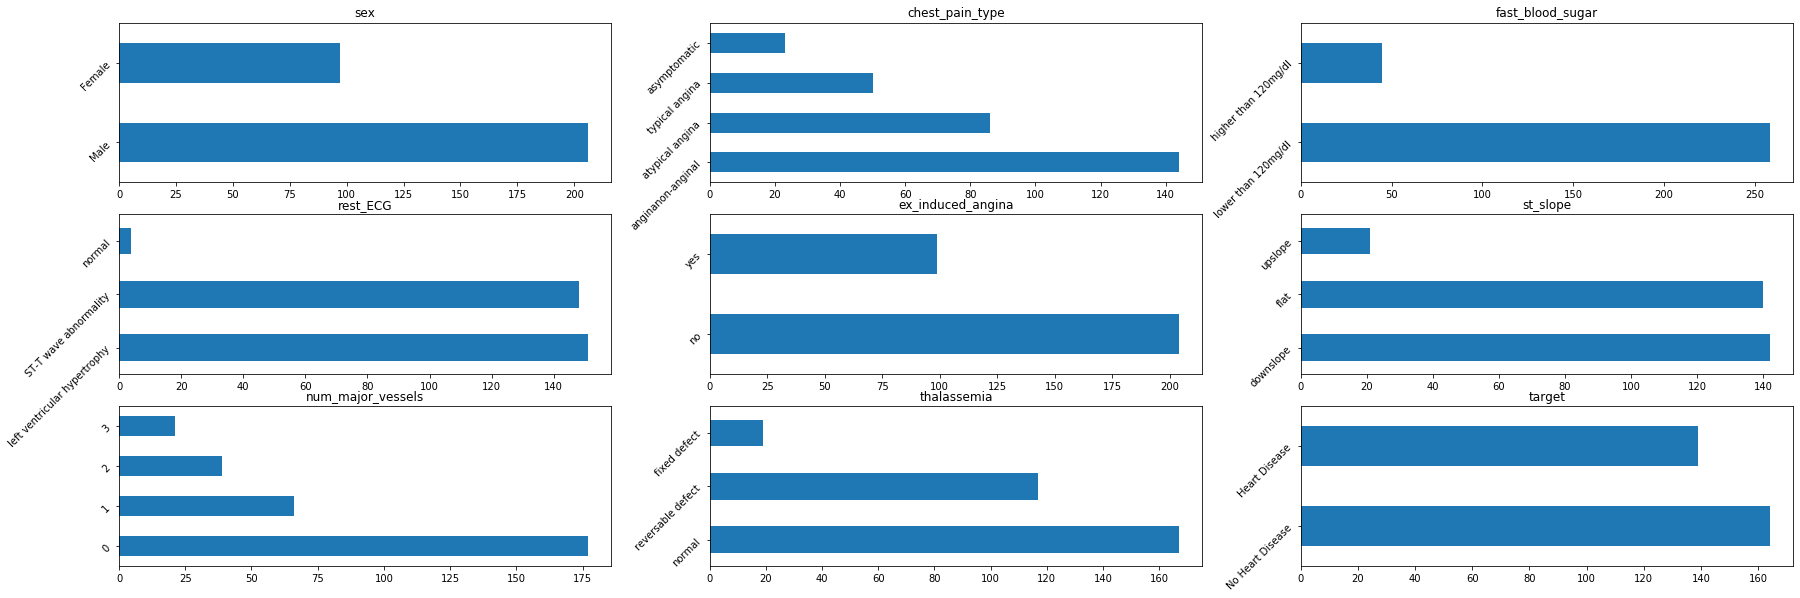

In [82]:
# Frequency plots for catergorical features
fig = plt.figure(figsize=(30,10))
for count, col in enumerate(heart.select_dtypes(include=['category','object']).columns):
    fig.add_subplot(3,3,count+1)
    heart[col].value_counts().plot.barh()
    plt.title(col)
    plt.yticks(rotation=45)

In [83]:
heart.head()

,age,sex,chest_pain_type,rest_BP,cholesterol,fast_blood_sugar,rest_ECG,max_HR,ex_induced_angina,ST_depression,st_slope,num_major_vessels,thalassemia,target
0,63,Male,asymptomatic,145,233,higher than 120mg/dl,ST-T wave abnormality,150,no,2.3,upslope,0,fixed defect,No Heart Disease
1,67,Male,anginanon-anginal,160,286,lower than 120mg/dl,ST-T wave abnormality,108,yes,1.5,flat,3,normal,Heart Disease
2,67,Male,anginanon-anginal,120,229,lower than 120mg/dl,ST-T wave abnormality,129,yes,2.6,flat,2,reversable defect,Heart Disease
3,37,Male,atypical angina,130,250,lower than 120mg/dl,left ventricular hypertrophy,187,no,3.5,upslope,0,normal,No Heart Disease
4,41,Female,typical angina,130,204,lower than 120mg/dl,ST-T wave abnormality,172,no,1.4,downslope,0,normal,No Heart Disease


<a id='Multicollinearity'></a>
### **2.2 Multicollinearity** ###

Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model. Multicollinearity can be a problem in a regression model because we would not be able to distinguish between the individual effects of the independent variables on the dependent variable.

Useful link: https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

If our goal is one of classification or prediction and not to look at the importance or contribution of each feature, we do not need to deal with multicollinearity as it does not affect the overall prediction or goodness of fit. It just affects the p-value and the coefficients. Since the goal of the project here is to predict heart disease as accurately as possible, we do not need to care about multicollinearity. However, let's just have a look to explore the relationships between our variables.



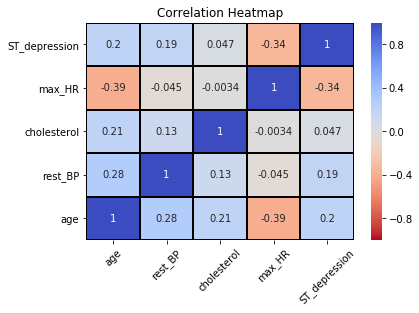

In [84]:
# Correlation heatmap
ax = sns.heatmap(heart.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1)
ax.set_ylim(0 ,5)
plt.xticks(rotation=45)
plt.title('Correlation Heatmap')
fig.show()

Age is slightly correlated with all variables except max heart rate, which is moderately negatively correlated. People who are older tend to have lower max heart rate. Max heart rate is also negatively correlated with ST_depression. Let's look at their variance inflation factor (VIF) values, tolerance (1/VIF) and mean of VIF.

* If the **largest VIF** is greater than 10 then there is cause for concern (Bowerman & O’Connell, 1990; Myers, 1990)
* If the **average VIF** is substantially greater than 1 then the regression may be biased (Bowerman & O’Connell, 1990).
* **Tolerance** below 0.1 indicates a serious problem.
* **Tolerance** below 0.2 indicates a potential problem (Menard, 1995).


In [85]:
# Multicollinearity
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

calc_vif(heart.select_dtypes(include=['int64','float64']))



,variables,VIF,tolerance,meanVIF
0,age,36.685632,0.027259,29.684608
1,rest_BP,55.971579,0.017866,29.684608
2,cholesterol,24.354973,0.041059,29.684608
3,max_HR,29.326738,0.034099,29.684608
4,ST_depression,2.084119,0.479819,29.684608


In [86]:
# drop feature with highest VIF
calc_vif(heart.select_dtypes(include=['int64','float64']).drop(['rest_BP'],axis=1))


,variables,VIF,tolerance,meanVIF
0,age,24.663117,0.040546,17.581506
1,cholesterol,23.851692,0.041926,17.581506
2,max_HR,19.841319,0.050400,17.581506
3,ST_depression,1.969897,0.507641,17.581506


There is definitely multicollinearity in our continuous features. Even after removing resting blood pressure, which is the one with the highest VIF value, we still have high VIF values that are way higher than the accepted threshold. Since our goal is one of prediction, we do not need to worry too much about it. However, we should not make any conclusions about the importance/contribution of each feature based on their coefficients when using regression.

Let's further explore their relationship with age while grouping by gender or heart disease diagnosis.

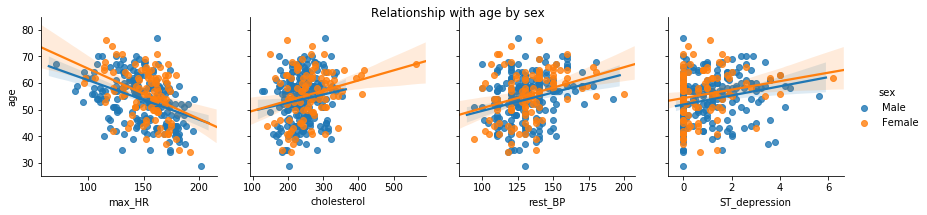

In [87]:
#sns.lmplot(x="age", y="max_HR", hue="sex", data=heart)
sns.pairplot(heart, x_vars=["max_HR", "cholesterol", "rest_BP", "ST_depression"], y_vars=["age"],
             hue="sex", height=3, aspect=1, kind="reg");
plt.suptitle('Relationship with age by sex')
plt.show()

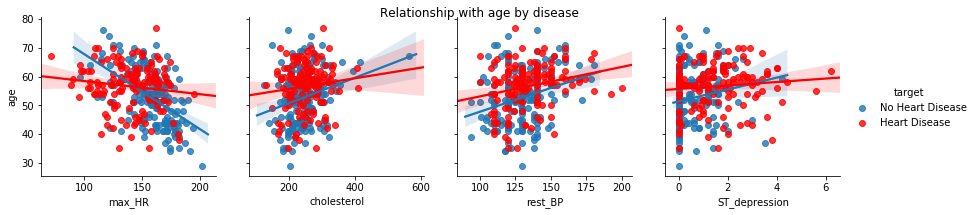

In [88]:
#sns.lmplot(x="age", y="max_HR", hue="sex", data=heart)
sns.pairplot(heart, x_vars=["max_HR", "cholesterol", "rest_BP", "ST_depression"], y_vars=["age"],
             hue="target", palette={'No Heart Disease':'tab:blue','Heart Disease':'red'}, height=3, aspect=1, kind="reg");
plt.suptitle('Relationship with age by disease')
plt.show()

It appears that the relationships between age and max heart rate, cholesterol, resting blood pressure and ST depression are stronger for people with no heart disease. However, for cholesterol, resting blood pressure and ST depression, the relationship difference between heart and no heart disease is smaller compared to max heart rate. None of the scatterplots show a clear separation of disease diagnosis, suggesting that none of these variables by themselves can predict the onset of heart disease.


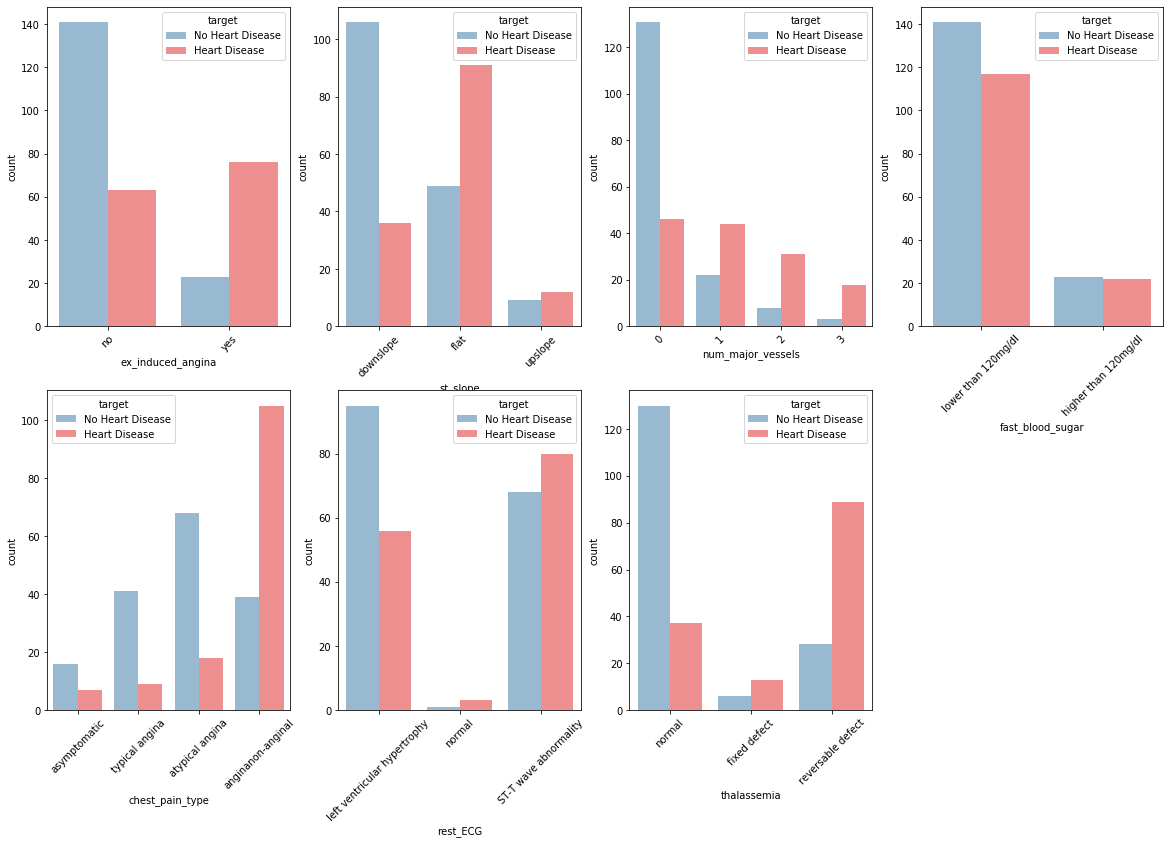

In [89]:
# Frequency by disease and levels of categorical features

fig = plt.figure(figsize=(20,20))
for count, col in enumerate(['ex_induced_angina','st_slope','num_major_vessels', 'fast_blood_sugar', 'chest_pain_type', 'rest_ECG', 'thalassemia']):
    fig.add_subplot(3,4,count+1)
    sns.countplot(x=col, hue="target", palette={'No Heart Disease':'tab:blue','Heart Disease':'red'}, alpha=.5, data=heart)
    plt.xticks(rotation=45)
 

Here, we see that for all the categorical features, all of them have at least a level that differentiates heart disease diagnosis. For example, for the case of type of chest pain, asymptomatic, typical  and atypical angina were all experienced more frequently by people with no heart disease while anginanon-anginal chest pain had a higher occurence among heart disease patients. This gives us confidence that these features will at least be somewhat useful in predicting heart disease, but that remains to be determined by modelling. 

Also, we can actually reduce the number of levels/catergories in each feature to just 2. For example, for chest pain type, since only anginanon-anginal has a higher frequency of heart disease than no heart disease, it can be its own level while the other 3 can be grouped into just 1 level (other pain). This removes the need for one-hot encoding, which might lead to further multicollienearity problem. This step is performed under 4.1. Binarize categorical features

<a id='Final_cleaning'></a>
## **3. Final Cleaning** ##

<a id='Outliers'></a>
### **3.1 Removing outliers using mahalanobis distance** ###

Mahalonobis distance is the distance between a point and a distribution. And not between two distinct points. It is effectively a multivariate equivalent of the Euclidean distance and is much better than detecting outliers for each feature individually.

In [90]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

df_x = heart.select_dtypes(include=['int64','float64'])
df_x['mahala'] = mahalanobis(x=df_x, data=heart.select_dtypes(include=['int64','float64']))
df_x.head()


,age,rest_BP,cholesterol,max_HR,ST_depression,mahala
0,63,145,233,150,2.3,2.659045
1,67,160,286,108,1.5,6.297799
2,67,120,229,129,2.6,5.045250
3,37,130,250,187,3.5,13.578678
4,41,130,204,172,1.4,3.407108


In [105]:
from scipy.stats import chi2
threshold = chi2.ppf((1-0.001), df=5) # Tabachnick & Fidell (2007) suggest probability estimate of 0.001 to calculate threshold

heart = heart[df_x['mahala'] <= threshold] # remove outliers
df_x[df_x['mahala'] > threshold] # show outliers

,age,rest_BP,cholesterol,max_HR,ST_depression,mahala
91,62,160,164,145,6.2,26.458942
126,56,200,288,133,4.0,20.589917
152,67,115,564,160,1.6,41.984886


In [112]:
heart.describe()

,age,rest_BP,cholesterol,max_HR,ST_depression
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,54.366667,131.423333,245.773333,149.643333,1.010667
std,9.043497,17.133866,48.389950,22.959965,1.114162
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.750000,120.000000,211.000000,133.750000,0.000000
50%,55.000000,130.000000,240.500000,153.000000,0.750000
75%,61.000000,140.000000,274.250000,166.000000,1.600000
max,77.000000,192.000000,417.000000,202.000000,5.600000


We can see that by using mahalanobis distance, the person with extreme cholesterol is highlighted as an outlier together with 2 others. The 1st person has very high ST depression (mean of the sample is ~1) while the 2nd person has very high resting blood pressure (mean of sample is ~ 130) and ST depression. They are removed from subsequent analyses.

In [110]:
heart

,age,sex,chest_pain_type,rest_BP,cholesterol,fast_blood_sugar,rest_ECG,max_HR,ex_induced_angina,ST_depression,st_slope,num_major_vessels,thalassemia,target
0,63,Male,asymptomatic,145,233,higher than 120mg/dl,ST-T wave abnormality,150,no,2.3,upslope,0,fixed defect,No Heart Disease
1,67,Male,anginanon-anginal,160,286,lower than 120mg/dl,ST-T wave abnormality,108,yes,1.5,flat,3,normal,Heart Disease
2,67,Male,anginanon-anginal,120,229,lower than 120mg/dl,ST-T wave abnormality,129,yes,2.6,flat,2,reversable defect,Heart Disease
3,37,Male,atypical angina,130,250,lower than 120mg/dl,left ventricular hypertrophy,187,no,3.5,upslope,0,normal,No Heart Disease
4,41,Female,typical angina,130,204,lower than 120mg/dl,ST-T wave abnormality,172,no,1.4,downslope,0,normal,No Heart Disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,Male,asymptomatic,110,264,lower than 120mg/dl,left ventricular hypertrophy,132,no,1.2,flat,0,reversable defect,Heart Disease
299,68,Male,anginanon-anginal,144,193,higher than 120mg/dl,left ventricular hypertrophy,141,no,3.4,flat,2,reversable defect,Heart Disease
300,57,Male,anginanon-anginal,130,131,lower than 120mg/dl,left ventricular hypertrophy,115,yes,1.2,flat,1,reversable defect,Heart Disease
301,57,Female,typical angina,130,236,lower than 120mg/dl,ST-T wave abnormality,174,no,0.0,flat,1,normal,Heart Disease


<a id='Wrangling'></a>
## **4. Data Wrangling** ##

<a id='Binarize'></a>
### **4.1. Binarize categorical features** ###

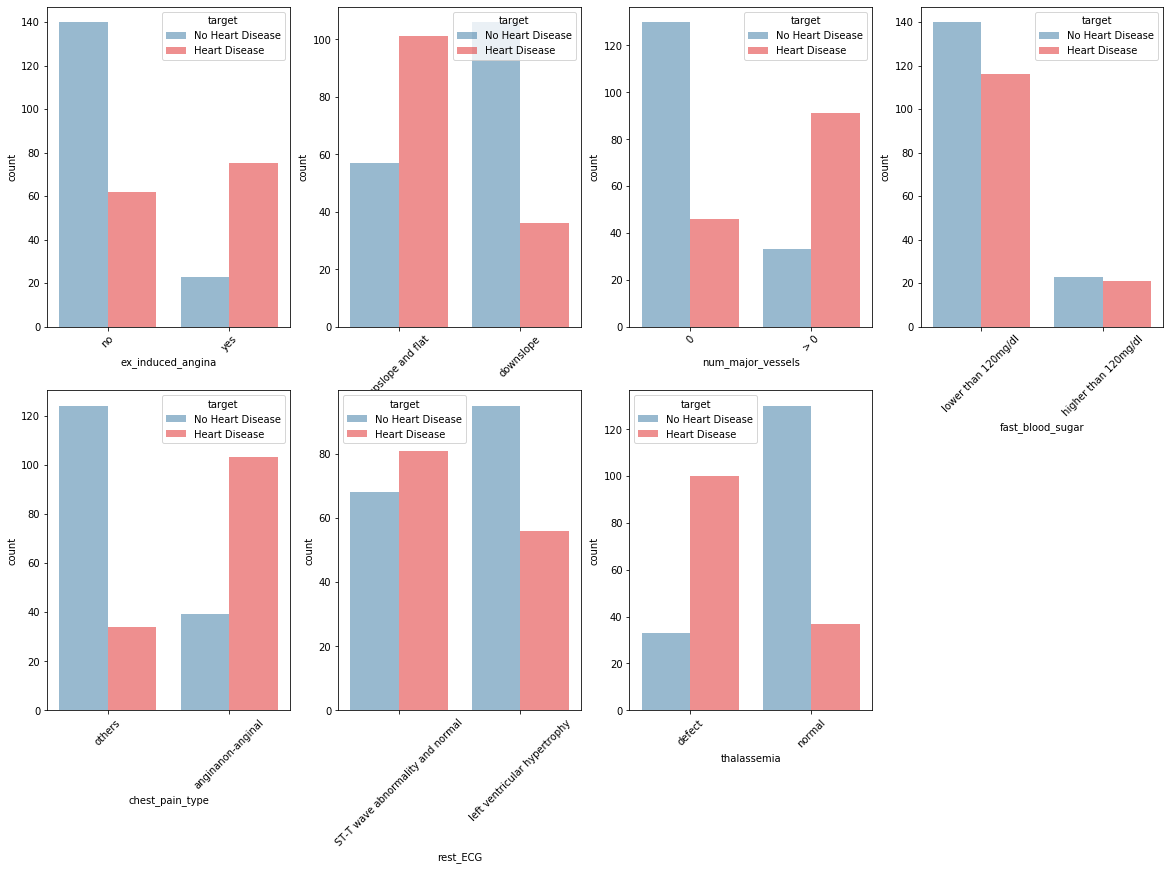

In [163]:
heart.chest_pain_type = ['anginanon-anginal' if i == 'anginanon-anginal' else 'others' for i in heart.chest_pain_type]
heart.rest_ECG = ['left ventricular hypertrophy' if i == 'left ventricular hypertrophy' else 'ST-T wave abnormality and normal' for i in heart.rest_ECG]
heart.st_slope = ['downslope' if i == 'downslope' else 'upslope and flat' for i in heart.st_slope]
heart.num_major_vessels = ['0' if i == '0' else '> 0' for i in heart.num_major_vessels]
heart.thalassemia = ['normal' if i == 'normal' else 'defect' for i in heart.thalassemia]

fig = plt.figure(figsize=(20,20))
for count, col in enumerate(['ex_induced_angina','st_slope','num_major_vessels', 'fast_blood_sugar', 'chest_pain_type', 'rest_ECG', 'thalassemia']):
    fig.add_subplot(3,4,count+1)
    sns.countplot(x=col, hue="target", palette={'No Heart Disease':'tab:blue','Heart Disease':'red'}, alpha=.5, data=heart)
    plt.xticks(rotation=45)



In [123]:
heart.head()

,age,sex,chest_pain_type,rest_BP,cholesterol,fast_blood_sugar,rest_ECG,max_HR,ex_induced_angina,ST_depression,st_slope,num_major_vessels,thalassemia,target
0,63,Male,others,145,233,higher than 120mg/dl,ST-T wave abnormality and normal,150,no,2.3,upslope and flat,0,defect,No Heart Disease
1,67,Male,anginanon-anginal,160,286,lower than 120mg/dl,ST-T wave abnormality and normal,108,yes,1.5,upslope and flat,> 0,normal,Heart Disease
2,67,Male,anginanon-anginal,120,229,lower than 120mg/dl,ST-T wave abnormality and normal,129,yes,2.6,upslope and flat,> 0,defect,Heart Disease
3,37,Male,others,130,250,lower than 120mg/dl,left ventricular hypertrophy,187,no,3.5,upslope and flat,0,normal,No Heart Disease
4,41,Female,others,130,204,lower than 120mg/dl,ST-T wave abnormality and normal,172,no,1.4,downslope,0,normal,No Heart Disease


<a id='Scaling'></a>
### **4.2. Features scaling** ###

In [190]:
y = heart[['target']]
x = heart.drop('target', axis=1)

# scale the continuous variables
for cont in ['age','rest_BP','cholesterol','max_HR','ST_depression']:
    x[cont] = (x[cont] - x[cont].mean()) / x[cont].std()

<a id='Encoding'></a>
### **4.3. Label Encoding** ###

In [191]:
# encode categorical features to 1 and 0
labelencoder = {"sex": {"Female": 0, "Male": 1},
                "chest_pain_type": {"others": 0, "anginanon-anginal": 1},
                "fast_blood_sugar": {"lower than 120mg/dl": 0, "higher than 120mg/dl": 1},
                "rest_ECG": {"left ventricular hypertrophy": 0, "ST-T wave abnormality and normal": 1},
                "ex_induced_angina": {"no": 0, "yes": 1},
                "st_slope": {"downslope": 0, "upslope and flat": 1},
                "num_major_vessels": {"0": 0, "> 0": 1},
                "thalassemia": {"normal": 0, "defect": 1},
                "target": {"No Heart Disease": 0, "Heart Disease": 1}}

x.replace(labelencoder, inplace=True)
y.replace(labelencoder, inplace=True)
x.head()

,age,sex,chest_pain_type,rest_BP,cholesterol,fast_blood_sugar,rest_ECG,max_HR,ex_induced_angina,ST_depression,st_slope,num_major_vessels,thalassemia
0,0.954645,1,0,0.792388,-0.263967,1,1,0.015534,0,1.157222,1,0,1
1,1.396952,1,1,1.667847,0.831302,0,1,-1.813737,1,0.439194,1,1,0
2,1.396952,1,1,-0.666711,-0.346628,0,1,-0.899101,1,1.426483,1,1,1
3,-1.920349,1,0,-0.083071,0.087346,0,0,1.627035,0,2.234265,1,0,0
4,-1.478042,0,0,-0.083071,-0.863265,0,1,0.973724,0,0.349440,0,0,0


In [201]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3,random_state=0)

print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (210, 13)
x_test shape:  (90, 13)
y_train shape:  (210, 1)
y_test shape:  (90, 1)


In [202]:
x_train.T

,285,44,275,192,155,161,102,54,184,18,...,245,280,214,9,198,254,195,118,47,175
age,0.401762,0.733492,1.065222,-1.256888,1.728682,2.502719,0.291185,0.622915,0.622915,-0.704005,...,1.396952,0.291185,-0.261698,-0.151121,-0.482852,-1.256888,1.396952,0.954645,-0.482852,0.291185
sex,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
chest_pain_type,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
rest_BP,-1.016894,-0.083071,2.251486,0.033657,-0.083071,-0.374891,-0.199799,-0.083071,1.551119,-0.083071,...,-0.666711,-1.250350,-1.133622,0.500568,-0.666711,-0.958531,-1.833990,-0.083071,1.084208,1.200935
cholesterol,1.492596,1.740582,-0.387959,0.025350,1.575258,1.203280,1.182615,0.149342,1.223946,0.603982,...,-0.181305,1.843909,-0.325963,-0.883930,-0.036647,1.182615,1.099953,1.740582,-0.057312,0.583317
fast_blood_sugar,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
rest_ECG,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max_HR,-0.420006,0.843062,0.233305,-0.289344,-1.770183,0.538183,0.407521,-0.245790,0.494629,-0.463561,...,-3.425238,-0.289344,0.451075,0.233305,0.538183,1.365711,-1.073318,-0.768439,-0.942655,-2.684818
ex_induced_angina,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
ST_depression,3.042047,-0.907109,-0.368588,-0.817356,1.246976,-0.907109,-0.907109,0.349440,-0.907109,-0.727602,...,-0.009574,1.785497,-0.907109,1.875251,0.080180,0.169933,-0.099327,0.708455,1.426483,0.169933


<a id='Logistic Regression'></a>
## **5. Logistic Regression** ##

In [293]:
models_score = pd.DataFrame(columns=['Model','Accuracy','Precision','Recall','F1']) # initialize df to store models scores

In [294]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate

# function for regularized logistic regression using grid search cross validation to find optimal lambda value
def log_regression_reg(x, y, cv=10, penalty='l2'):
    lr = LogisticRegression(penalty=penalty)
    lambdas = {'C': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 50, 100, 1000]}
    log_regressor = GridSearchCV(lr, lambdas, scoring='f1', cv=cv, return_train_score=True)
    log_regressor.fit(x,y)
    best_c = log_regressor.best_params_['C']

    best_lr = LogisticRegression(C=best_c)
    scoring = ['accuracy','precision','recall','f1']
    scores = cross_validate(best_lr, x, y, cv=cv, scoring=scoring, return_train_score=True)
    return {'Accuracy': scores['test_accuracy'].mean().round(3), 'Precision': scores['test_precision'].mean().round(3), 
        'Recall': scores['test_recall'].mean().round(3), 'F1': scores['test_f1'].mean().round(3)}

In [295]:
# L2 Logistic Regression (ridge regression)/ logistic regression with L2 regularization
L2_Log_Regression = log_regression_reg(x,y, cv=10, penalty='l2')
d = {'Model': 'L2 Log Regression'}
d.update(L2_Log_Regression)
models_score = models_score.append(d, ignore_index=True) # add model scores to df
L2_Log_Regression

C:\Users\TeYan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'Accuracy': 0.846, 'Precision': 0.855, 'Recall': 0.801, 'F1': 0.824}

In [297]:
# L1 Logistic Regression (lasso regression)/ logistic regression with L1 regularization
L1_Log_Regression = log_regression_reg(x,y, cv=10, penalty='l1')
d = {'Model': 'L1 Log Regression'}
d.update(L1_Log_Regression)
models_score = models_score.append(d, ignore_index=True) # add model scores to df
L1_Log_Regression

C:\Users\TeYan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'Accuracy': 0.843, 'Precision': 0.843, 'Recall': 0.808, 'F1': 0.822}